In [1]:
import os
#os.chdir('/Users/rupesh.karn/Desktop/WorkPart-1/UNSW-NB15 Dataset')
import pandas as pd
import numpy as np
import csv
import os
import time
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

# Read in the training CSV file
print("Reading Training csv file.")
df1 = pd.read_csv("UNSW_NB15_training-set.csv")
df1.drop('label', axis=1, inplace=True)

obj_df=df1

obj_df["proto"] = obj_df["proto"].astype('category')
obj_df["service"] = obj_df["service"].astype('category')
obj_df["state"] = obj_df["state"].astype('category')
obj_df["proto_cat"] = obj_df["proto"].cat.codes
obj_df["service_cat"] = obj_df["service"].cat.codes
obj_df["state_cat"] = obj_df["state"].cat.codes

obj_df["proto"] = obj_df["proto_cat"]
obj_df["service"] = obj_df["service_cat"]
obj_df["state"] = obj_df["state_cat"]

obj_df.drop('proto_cat', axis=1, inplace=True)
obj_df.drop('service_cat', axis=1, inplace=True)
obj_df.drop('state_cat', axis=1, inplace=True)

Y_train_all_attacks = obj_df["attack_cat"]
obj_df=pd.get_dummies(obj_df, columns=["attack_cat"])


X_train = obj_df.values[:,:-10]


for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_train)):
        X_train[i,j] = round(X_train[i,j]/maximum,3)

# Read in the testing CSV file 
print("Reading Testing csv file.")
df2 = pd.read_csv("UNSW_NB15_testing-set.csv")
df2.drop('label', axis=1, inplace=True)

obj_df2=df2

obj_df2["proto"] = obj_df2["proto"].astype('category')
obj_df2["service"] = obj_df2["service"].astype('category')
obj_df2["state"] = obj_df2["state"].astype('category')
obj_df2["proto_cat"] = obj_df2["proto"].cat.codes
obj_df2["service_cat"] = obj_df2["service"].cat.codes
obj_df2["state_cat"] = obj_df2["state"].cat.codes

obj_df2["proto"] = obj_df2["proto_cat"]
obj_df2["service"] = obj_df2["service_cat"]
obj_df2["state"] = obj_df2["state_cat"]

obj_df2.drop('proto_cat', axis=1, inplace=True)
obj_df2.drop('service_cat', axis=1, inplace=True)
obj_df2.drop('state_cat', axis=1, inplace=True)

Y_test_all_attacks = obj_df2["attack_cat"]
obj_df2=pd.get_dummies(obj_df2, columns=["attack_cat"])


X_test = obj_df2.values[:,:-10]


for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_test)):
        X_test[i,j] = round(X_test[i,j]/maximum,3)


estimators_number = list(range(10,30))

dataspace = 0;
overall_accuracy_matrix = [None]*len(X_train)
iTERATION=0
dataspace_number=1
attack_type = 4
Y_train = obj_df.values[:,-attack_type]
Y_test = obj_df2.values[:,-attack_type]

cleanup_nums = {"Worms":0, "Shellcode":1, "Reconnaissance":2, "Normal":3, "Generic":4, "Fuzzers":5, "Exploits":6, "DoS":7, "Backdoor":8, "Analysis":9}
Y_train_all_attacks.replace(cleanup_nums,inplace=True)
Y_test_all_attacks.replace(cleanup_nums,inplace=True)

Reading Training csv file.
Reading Testing csv file.


In [14]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

select = tf.select if hasattr(tf, 'select') else tf.where

#Creating dataset with only 35 features out of 43
feature_set = 35
X_train_reduced = X_train[:,:feature_set]
X_test_reduced = X_test[:,:feature_set]
X_train_reduced.shape, X_test_reduced.shape

# Data params
input_dim = 43
output_dim = 10

# Network params
n_hidden_units = 43
activation_fn = tf.nn.relu

# Optimization params
batch_size = 64
epochs_per_task = 10

n_stats = 1

# Reset optimizer after each age
reset_optimizer = True

from keras.utils import np_utils
from sklearn.decomposition import PCA
pca = PCA(n_components=35)

#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9],[3,8],[0,6],[4,2]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]]
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
n_tasks = len(task_labels)
nb_classes  = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['select']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [19]:
def create_dataset(feature_set_reduce_flag=0):
    training_datasets = []
    validation_datasets = []
    multihead=False
    if feature_set_reduce_flag == 1:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=feature_set)
        Y_train = Y_train_all_attacks; Y_test = Y_test_all_attacks
        for labels in task_labels:
            idx = np.in1d(Y_train, labels)
            if multihead:
                label_map = np.arange(nb_classes)
                label_map[labels] = np.arange(len(labels))
                if labels == [0,1] or labels ==[2,3]:
                    data = X_train_reduced[idx], np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
                else:
                    dimesnion_reduced = pca.fit_transform(X_train[idx])
                    data = dimesnion_reduced, np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
            else:
                if labels == [0,1] or labels ==[2,3]:
                    data = X_train_reduced[idx], np_utils.to_categorical(Y_train[idx], nb_classes)
                else:
                    dimesnion_reduced = pca.fit_transform(X_train[idx])
                    data = dimesnion_reduced, np_utils.to_categorical(Y_train[idx], nb_classes)
                training_datasets.append(data)

        for labels in task_labels:
            idx = np.in1d(Y_test, labels)
            if multihead:
                label_map = np.arange(nb_classes)
                label_map[labels] = np.arange(len(labels))
                if labels == [0,1] or labels ==[2,3]:
                    data = X_test_reduced[idx], np_utils.to_categorical(label_map[Y_test[idx]], len(labels))
                else:
                    dimesnion_reduced = pca.fit_transform(X_test[idx])
                    data = dimesnion_reduced, np_utils.to_categorical(label_map[Y_test[idx]], len(labels))
            else:
                if labels == [0,1] or labels ==[2,3]:
                    data = X_test_reduced[idx], np_utils.to_categorical(Y_test[idx], nb_classes)
                else:
                    dimesnion_reduced = pca.fit_transform(X_test[idx])
                    data = dimesnion_reduced, np_utils.to_categorical(Y_test[idx], nb_classes)
                validation_datasets.append(data)
    else:
        for labels in task_labels:
            idx = np.in1d(Y_train_all_attacks, labels)
            if multihead:
                label_map = np.arange(nb_classes)
                label_map[labels] = np.arange(len(labels))
                data = X_train[idx], np_utils.to_categorical(label_map[Y_train_all_attacks[idx]], len(labels))
            else:
                data = X_train[idx], np_utils.to_categorical(Y_train_all_attacks[idx], nb_classes)
                training_datasets.append(data)

        for labels in task_labels:
            idx = np.in1d(Y_test_all_attacks, labels)
            if multihead:
                label_map = np.arange(nb_classes)
                label_map[labels] = np.arange(len(labels))
                data = X_test[idx], np_utils.to_categorical(label_map[Y_test_all_attacks[idx]], len(labels))
            else:
                data = X_test[idx], np_utils.to_categorical(Y_test_all_attacks[idx], nb_classes)
                validation_datasets.append(data)
    return(training_datasets,validation_datasets)

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory
from keras.callbacks import LambdaCallback

def create_model(feature_set_reduce_flag=0):
    model = Sequential()
    if feature_set_reduce_flag == 0:
        model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn, input_shape=(input_dim,)))
    else:
        model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn, input_shape=(feature_set,)))
    model.add(Dense(n_hidden_units, kernel_initializer='random_uniform', activation=activation_fn))
    #model.add(Dense(n_hidden_units, activation=activation_fn))
    model.add(Dense(output_dim, kernel_initializer='random_uniform', activation=masked_softmax))

    #protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
    protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
    #protocol_name, protocol = protocols.FISHER_PROTOCOL('sum')
    opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
    #opt = SGD(1e-3)
    #opt = RMSprop(lr=1e-3)
    oopt = KOOptimizer(opt, model=model, **protocol)
    model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
    model.model._make_train_function()
    saved_weights = model.get_weights()
    
    save_weights_epoch=[]
    save_loss_epoch=[]
    print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: save_weights_epoch.append(model.get_weights()))
    history = LossHistory()
    callbacks = [history, print_weights]
    return(model,oopt,callbacks)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [20]:
def run_fits(cvals, eval_on_train_set=False, nstats=1, feature_set_reduce=[0]):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    for featureset_flag in feature_set_reduce:
        training_data,valid_data = create_dataset(featureset_flag)
        model,oopt,callbacks = create_model(featureset_flag)
        for cidx, cval_ in enumerate(tqdm(cvals)):
            runs = []
            for runid in range(nstats):
                sess.run(tf.global_variables_initializer())
                # model.set_weights(saved_weights)
                cstuffs = []
                evals = []
                print("setting cval")
                cval = cval_
                oopt.set_strength(cval)
                oopt.init_task_vars()
                print("cval is", sess.run(oopt.lam))
                for age, tidx in enumerate(range(n_tasks)):
                    print("Age %i, cval is=%f"%(age,cval))
                    print("settint output mask")
                    set_active_outputs(task_labels[age])
                    stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=callbacks)
                    oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                    oopt.update_task_vars()
                    ftask = []
                    model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                    for j in range(n_tasks):
                        set_active_outputs(task_labels[j])
                        if eval_on_train_set:
                            f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                        else:
                            f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                        ftask.append(np.mean(f_))
                    evals.append(ftask)
                    cstuffs.append(stuffs)

                    # Re-initialize optimizater variables
                    if reset_optimizer:
                        oopt.reset_optimizer()

                evals = np.array(evals)
                runs.append(evals)

            runs = np.array(runs)
            acc_mean[featureset_flag] = runs.mean(0)
            acc_std[featureset_flag] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save,callbacks

In [21]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
#cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [1.0]
feature_set_reduce = [0,1]
print(feature_set_reduce)

[0, 1]


In [22]:
#%%capture

recompute_data = True

if recompute_data:
    data,model_weights_save,history = run_fits(cvals, eval_on_train_set=False, nstats=n_stats, feature_set_reduce=feature_set_reduce)

  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 1/10
422/422 [==============================] - 0s - loss: 0.6898 - acc: 0.8318     
Epoch 2/10
422/422 [==============================] - 0s - loss: 0.6787 - acc: 0.8957     
Epoch 3/10
422/422 [==============================] - 0s - loss: 0.6614 - acc: 0.8957     
Epoch 4/10
422/422 [==============================] - 0s - loss: 0.6309 - acc: 0.8957     
Epoch 5/10
422/422 [==============================] - 0s - loss: 0.5821 - acc: 0.8957     
Epoch 6/10
422/422 [==============================] - 0s - loss: 0.5182 - acc: 0.8957     
Epoch 7/10
422/422 [==============================] - 0s - loss: 0.4378 - acc: 0.8957     
Epoch 8/10
422/422 [==============================] - 0s - loss: 0.3888 - acc: 0.8957     
Epoch 9/10
422/422 [==============================] - 0s - loss: 0.3568 - acc: 0.8957     
Epoch 10/10
422/422 [==============================] - 0s - loss: 0.3496 - acc: 

100%|██████████| 1/1 [00:41<00:00, 41.48s/it]

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]



  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 1/10
422/422 [==============================] - 0s - loss: 0.6885 - acc: 0.8957     
Epoch 2/10
422/422 [==============================] - 0s - loss: 0.6738 - acc: 0.8957     
Epoch 3/10
422/422 [==============================] - 0s - loss: 0.6471 - acc: 0.8957     
Epoch 4/10
422/422 [==============================] - 0s - loss: 0.5998 - acc: 0.8957     
Epoch 5/10
422/422 [==============================] - 0s - loss: 0.5340 - acc: 0.8957     
Epoch 6/10
422/422 [==============================] - 0s - loss: 0.4498 - acc: 0.8957     
Epoch 7/10
422/422 [==============================] - 0s - loss: 0.3899 - acc: 0.8957     
Epoch 8/10
422/422 [==============================] - 0s - loss: 0.3604 - acc: 0.8957     
Epoch 9/10
422/422 [==============================] - 0s - loss: 0.3513 - acc: 0.8957     
Epoch 10/10
422/422 [==============================] - 0s - loss: 0.3385 - acc: 

100%|██████████| 1/1 [00:42<00:00, 42.93s/it]

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


In [23]:
print(create_model(1)[0].summary())

#Shape of the array containg model weights
weights = create_model(1)[0].get_weights()
for i in range(len(weights)):
    print((np.array(weights[i])).shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 43)                1548      
_________________________________________________________________
dense_8 (Dense)              (None, 43)                1892      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                440       
Total params: 3,880
Trainable params: 3,880
Non-trainable params: 0
_________________________________________________________________
None
(35, 43)
(43,)
(43, 43)
(43,)
(43, 10)
(10,)


In [29]:
#Inspection of behavior of importance parameter big_omega after every task 
from numpy import count_nonzero
last_epoch_batchindex = []
counter = 0
for i,j in enumerate(history[0].batchindex):
    try:
        if history[0].batchindex[i+1] > j:
            pass
        else:
            counter = counter+1
            if counter%epochs_per_task == 0:
                last_epoch_batchindex.append(i)
    except:
        last_epoch_batchindex.append(i)

print('Batch-id for last epoch of each task:',last_epoch_batchindex)
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history[0].big_omega[epoch_id].keys())
    print('Parameter importance (big_omega) for task {0} shape is '.format(i), [history[0].big_omega[epoch_id][ke].shape for ke in key]) 

non_zero_imp_param = []
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history[0].big_omega[epoch_id].keys())
    non_zero_imp_param.append(sum([count_nonzero(history[0].big_omega[epoch_id][ke]) for ke in key]))
    print('Number of non-zero elements of importance (big_omega) for task {0} is '.format(i), non_zero_imp_param[i])    

Batch-id for last epoch of each task: [69, 6399, 10299, 12679, 12879]
*----------------------------*
Parameter importance (big_omega) for task 0 shape is  [(43, 10), (43,), (43, 43), (43,), (10,), (35, 43)]
Parameter importance (big_omega) for task 1 shape is  [(43, 10), (43,), (43, 43), (43,), (10,), (35, 43)]
Parameter importance (big_omega) for task 2 shape is  [(43, 10), (43,), (43, 43), (43,), (10,), (35, 43)]
Parameter importance (big_omega) for task 3 shape is  [(43, 10), (43,), (43, 43), (43,), (10,), (35, 43)]
Parameter importance (big_omega) for task 4 shape is  [(43, 10), (43,), (43, 43), (43,), (10,), (35, 43)]
*----------------------------*
Number of non-zero elements of importance (big_omega) for task 0 is  0
Number of non-zero elements of importance (big_omega) for task 1 is  2492
Number of non-zero elements of importance (big_omega) for task 2 is  3225
Number of non-zero elements of importance (big_omega) for task 3 is  3646
Number of non-zero elements of importance (bi

In [48]:
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
mean_std_imp_param = []
flat_list_imp_param = []
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history[0].big_omega[epoch_id].keys())
    for ke in key:
        flat_list_imp_param.append(history[0].big_omega[epoch_id][ke]) 
    flat_list_imp_param = list(flatten(flat_list_imp_param))
    mean = np.mean(flat_list_imp_param)
    std = np.std(flat_list_imp_param)
    imp_threshold = np.abs(mean - std)
    mean_std_imp_param = [elem for elem in flat_list_imp_param if elem > imp_threshold ]  
    print('Mean: {}, Std: {}, Imp threshold: {}, Number of imp param: {}'.format(mean, std, imp_threshold, len(mean_std_imp_param)))
    flat_list_imp_param = []

*----------------------------*
Mean: 0.0, Std: 0.0, Imp threshold: 0.0, Number of imp param: 0
Mean: 0.023650960996747017, Std: 0.10523482412099838, Imp threshold: 0.08158386498689651, Number of imp param: 267
Mean: 0.8803673386573792, Std: 3.5907676219940186, Imp threshold: 2.710400342941284, Number of imp param: 296
Mean: 1.4226300716400146, Std: 4.2901129722595215, Imp threshold: 2.867482900619507, Number of imp param: 434
Mean: 1.8502869606018066, Std: 4.877017498016357, Imp threshold: 3.026730537414551, Number of imp param: 513


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(-5.0, 0.0)


/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


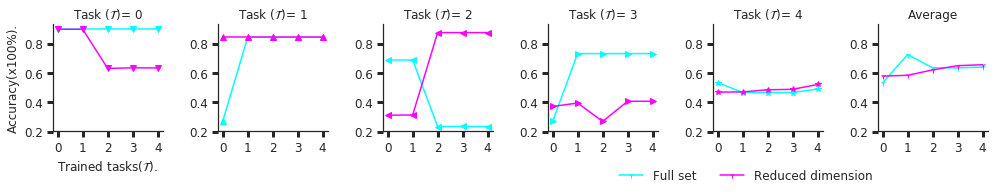

In [8]:
import matplotlib.colors as colors
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())
fontsize =12

figure(figsize=(14, 3))
axs = [subplot(1,n_tasks+1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)
marker=["v","^","<",">","*","1","o","+","."]

for feature_set_flag in sorted_keys:
    mean_vals = data['mean'][feature_set_flag]
    std_vals = data['std'][feature_set_flag]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(feature_set_flag))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal, marker=marker[j])
        axs[j].set_xticks(range(-1,n_tasks))
        axs[j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        axs[0].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
        axs[0].set_ylabel('Accuracy(x100%).',fontsize=fontsize)
        axs[j].tick_params(labelsize='large', width=3)
    label = ['Full set', 'Reduced dimension']
    average = mean_vals.mean(1)  #Taking the average of cross validation accuracies accross all tasks after learning each task
    axs[-1].plot(average, c=colorVal, label=label[feature_set_flag], marker=marker[j+1])
    axs[-1].tick_params(labelsize='large', width=3)
for i, ax in enumerate(axs):
    ax.legend(loc='upper right',prop={'size': fontsize}, bbox_to_anchor=(0.05, -0.25), ncol=2)
    ax.set_title((['Task ($\mathcal{T}$)= %d'%j for j in range(n_tasks)] + ['Average'])[i])
gcf().tight_layout()
sns.despine()
plt.savefig('UNSW-Progressive-Transfer-Learning.pdf')

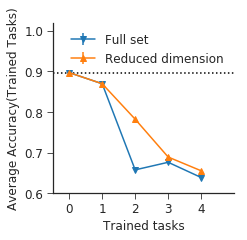

In [9]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
fig = plt.figure(figsize=(3.0,3.0))
ax = plt.subplot(111)

plot_keys =sorted(data['mean'].keys())# [0,1]

for cval in plot_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    label = ['Full set', 'Reduced dimension']
    errorbar(range(0,n_tasks), mean_stuff, yerr=std_stuff, marker=marker[cval], label=label[cval])
        
axhline(data['mean'][cval][0][0], linestyle=':', color='k')
xlabel('Trained tasks', fontsize=fontsize)
ylabel('Average Accuracy(Trained Tasks)', fontsize=fontsize)
legend(loc='best', fontsize=fontsize)
xlim(-0.5, n_tasks)
plt.yticks([0.6,0.7,0.8,0.9,1.0], fontsize=fontsize)
plt.xticks(range(0,n_tasks), fontsize=fontsize)
ylim(0.6, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.subplots_adjust(left=.15, bottom=.18, right=.99, top=.97)
plt.savefig("UNSW_avg_accuracy.pdf",bbox_inches = "tight")

In [10]:
#Before reducing dataset.
print('Before reduction.')
training_datasets,_ = create_dataset(feature_set_reduce_flag=0)
for j in range(n_tasks):
    print('Rank of data for task-{0} of shape-{1} is: {2}'.format(j,training_datasets[j][0].shape,matrix_rank(np.matrix(training_datasets[j][0], dtype='float'))))
    print('----------------------------------------------------------------------')

Before reduction.
Rank of data for task-0 of shape-(422, 43) is: 33
----------------------------------------------------------------------
Rank of data for task-1 of shape-(40496, 43) is: 43
----------------------------------------------------------------------
Rank of data for task-2 of shape-(24933, 43) is: 40
----------------------------------------------------------------------
Rank of data for task-3 of shape-(15221, 43) is: 41
----------------------------------------------------------------------
Rank of data for task-4 of shape-(1260, 43) is: 38
----------------------------------------------------------------------


In [11]:
#After reducing dataset to 35 features.
print('After reduction.')
training_datasets,_ = create_dataset(feature_set_reduce_flag=1)
for j in range(n_tasks):
    print('Rank of data for task-{0} of shape-{1} is: {2}'.format(j,training_datasets[j][0].shape,matrix_rank(np.matrix(training_datasets[j][0], dtype='float'))))
    print('----------------------------------------------------------------------')

After reduction.
Rank of data for task-0 of shape-(422, 35) is: 30
----------------------------------------------------------------------
Rank of data for task-1 of shape-(40496, 35) is: 35
----------------------------------------------------------------------
Rank of data for task-2 of shape-(24933, 35) is: 35
----------------------------------------------------------------------
Rank of data for task-3 of shape-(15221, 35) is: 35
----------------------------------------------------------------------
Rank of data for task-4 of shape-(1260, 35) is: 35
----------------------------------------------------------------------


In [12]:
#Rank of extended features
training_datasets,_ = create_dataset(feature_set_reduce_flag=0)
for j in range(n_tasks):
    print('Rank of extended features for task-{0} of shape-{1} is: {2}'.format(j,training_datasets[j][0][:,feature_set:].shape,matrix_rank(np.matrix(training_datasets[j][0][:,feature_set:], dtype='float'))))
    print('----------------------------------------------------------------------')

Rank of extended features for task-0 of shape-(422, 8) is: 5
----------------------------------------------------------------------
Rank of extended features for task-1 of shape-(40496, 8) is: 8
----------------------------------------------------------------------
Rank of extended features for task-2 of shape-(24933, 8) is: 6
----------------------------------------------------------------------
Rank of extended features for task-3 of shape-(15221, 8) is: 6
----------------------------------------------------------------------
Rank of extended features for task-4 of shape-(1260, 8) is: 5
----------------------------------------------------------------------
